# Notebook to run orbits of clusters and streams

You can read more about astropy units here:
https://docs.astropy.org/en/stable/units/index.html

You can read more about the gala pacakge which is used throughout this notebook for orbit integration, potentials etc here:
http://gala.adrian.pw/en/latest/

In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 22#label_size 
mpl.rcParams['ytick.labelsize'] =22 #label_size 

## Set up the potential models:

Load the new Gala Milky Way model:

In [3]:
# you'll need to change this path to the folder where you store the file I sent 
# I will send you this file
# this potential includes a dark matter halo, disk, and bulge + nucleus for the MW
mw = gp.load('MilkyWayPotential2022.yml')

In [4]:
xyz = np.zeros((3, 1024))
xyz[0] = np.linspace(0, 25, xyz.shape[1])

(0.0, 250.0)

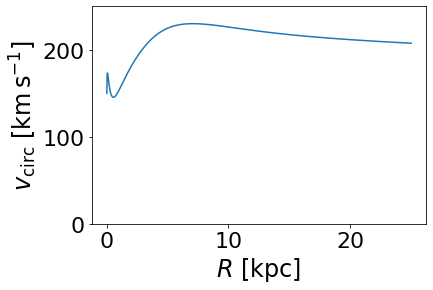

In [5]:
# plot the circular velocity of the potential with galactocentric radius
for pot in [mw]:
    vcirc = pot.circular_velocity(xyz)
    plt.plot(xyz[0], vcirc)
plt.xlabel('$R$ [kpc]')
plt.ylabel(r'$v_{\rm circ}$ ' + f'[{vcirc.unit:latex_inline}]')
plt.ylim(0, 250)

Plot the density at the midplane of the  potential model:

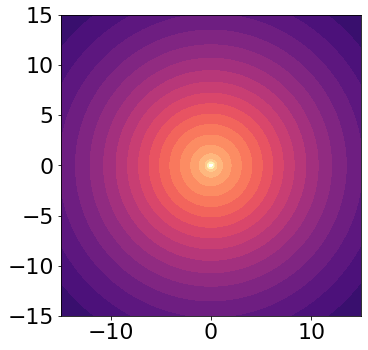

In [6]:
grid = (np.linspace(-15, 15, 128), np.linspace(-15, 15, 128), 0)
levels = np.geomspace(1e6, 1e10, 24)

fig, axes = plt.subplots(
    1, 1, 
    figsize=(5, 5), 
    sharex=True, sharey=True,
    constrained_layout=True
)
for pot in [mw]:
    pot.plot_density_contours(
    grid=grid, ax=axes, 
    levels=levels, cmap='magma', 
    norm=mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max()))
    axes.set_aspect('equal')

## Set up hamiltonian 

In [7]:

test_frame = gp.StaticFrame(galactic)

H = gp.Hamiltonian(mw, test_frame)


## Transform from 6d phase space sky coords to galactic coords

To integrate the orbits of streams and clusters you need their 6D phase space coordinates (ra,dec,distance,proper motion1,proper motion2, radial velocity) in galactic coordinates in your potential (x,y,z,vx,vy,vz)

See more info here  https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html

In [4]:
df = pd.read_fwf("input.txt")

In [5]:
def integrate_orbit(name,verbose=False,return_vals=False):

    index = df.loc[df['# Name'] == name].index[0]

    ra = df['ra'][index]*u.degree
    dec = df['dec'][index]*u.degree
    pm_ra = df['pmra'][index]*u.mas/u.yr
    pm_dec = df['pmdec'][index]*u.mas/u.yr
    vlos = df['vlos'][index]*u.km/u.s
    dist = df['dist'][index]*u.kpc


    c1 = coord.SkyCoord(ra=ra, dec=dec,
                        distance=dist,
                        pm_ra_cosdec=pm_ra,
                        pm_dec=pm_dec,
                        radial_velocity=vlos,
                        frame='icrs')

    gc1 = c1.transform_to(coord.Galactocentric)


    glob_w0 = gd.PhaseSpacePosition(
        [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
        [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
    )
    
    test_frame = gp.StaticFrame(galactic)

    H = gp.Hamiltonian(mw, test_frame)
    
    prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
    ).to_frame(test_frame)



    prog_orbit = H.integrate_orbit(
        glob_w0, 
        t=prog_orbit.t,
        Integrator=gi.DOPRI853Integrator
    )

    #print('orbit pericenter and apocenter')
    #here you can easily compute the orbital parameters such as apocenter/pericenter 
    #print(prog_orbit.pericenter(), prog_orbit.apocenter())
    if verbose:
        fig = prog_orbit.plot();
        fig.suptitle('Orbit in Milky Way-like potential', fontsize=24)
        
    if return_vals:
        return prog_orbit.pericenter().value, prog_orbit.apocenter().value

(9.89571398166642, 17.715680689896303)

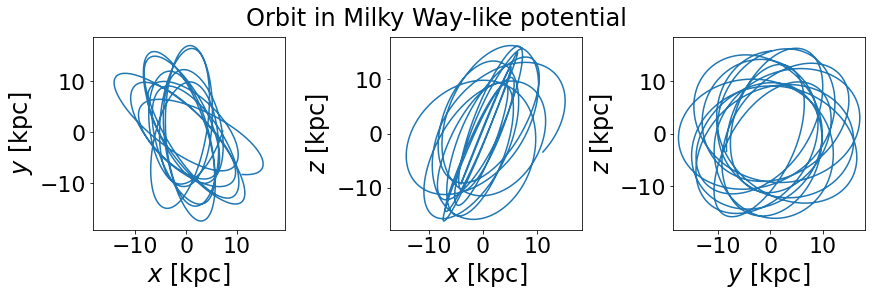

In [79]:
integrate_orbit(name='Pal_5',return_vals=True,verbose=True)

In [6]:
%%time
apocenters = np.zeros(len(df["# Name"]))
pericenters = np.zeros(len(df['# Name']))
for i,name in enumerate(df["# Name"]):
    try:
        pericenters[i] = integrate_orbit(name=name,return_vals=True)[0]
        apocenters[i] = integrate_orbit(name=name,return_vals=True)[1]
    except RuntimeError:
        pericenters[i] = float('nan')
        apocenters[i] = float('nan')

df['apocenter'] = apocenters
df['pericenter'] = pericenters

CPU times: user 33 s, sys: 528 ms, total: 33.5 s
Wall time: 33.9 s


In [6]:
df.keys()

Index(['# Name', 'ra', 'dec', 'dist', 'disterr', 'vlos', 'vloserr', 'sigma',
       'rmax', 'pmra', 'pmdec', 'plx', 'pmra_e', 'pmdec_e', 'pmcorr', 'plx_e'],
      dtype='object')

In [54]:
key = "5139_oCen"

df['# Name'][13]

'Ko_2'

In [51]:
# example of cluster 6D sky coordinates
# below I use the Pal 5 GC coordinates from Vasiliev et al. 2021

c1 = coord.SkyCoord(ra=229.019*u.degree, dec=-0.121*u.degree,
                    distance=20.6*u.kpc,
                    pm_ra_cosdec=-2.730 *u.mas/u.yr,
                    pm_dec=-2.654 *u.mas/u.yr,
                    radial_velocity=-56.2 *u.km/u.s,
                    frame='icrs')

In [86]:
len(df)

170

In [77]:
count = 0
for i in pericenters:
    if (np.isnan(i)):
        count += 1
print(count)
       

9


In [85]:
len(df.loc[df["pericenter"] < 10]["pericenter"])

140

In [30]:
#now transform to galactocentric coords (assuming default solar vel + pos - see link above)
gc1 = c1.transform_to(coord.Galactocentric)

In [17]:
print(gc1.x, gc1.y, gc1.z)
print(gc1.v_x, gc1.v_y, gc1.v_z)


7.1970585973536085 kpc 0.22364519881190617 kpc 15.725603167408744 kpc
-45.683760871576744 km / s -149.92448254498515 km / s -11.322419809788432 km / s


## Compute the orbit of the cluster :

We select Pal 5's progenitor orbit from above

In [18]:
glob_w0 = gd.PhaseSpacePosition(
    [gc1.x.value,  gc1.y.value,  gc1.z.value] * u.kpc ,
    [gc1.v_x.value,  gc1.v_y.value,  gc1.v_z.value]*u.km/u.s
)
prog_orbit = H.integrate_orbit(
    glob_w0, 
    dt=1, t1=0, t2=5*u.Gyr, 
    Integrator=gi.DOPRI853Integrator
).to_frame(test_frame)

print(prog_orbit.pericenter(), prog_orbit.apocenter())

9.89571398166642 kpc 17.715680689896303 kpc


Compare orbit plot to orbit in static (non-barred) potential:

orbit pericenter and apocenter
9.89571398166642 kpc 17.715680689896303 kpc


Text(0.5, 0.98, 'Orbit in Milky Way-like potential')

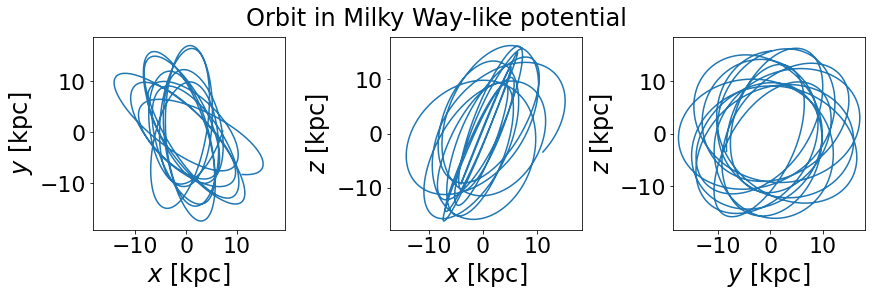

In [29]:
prog_orbit = H.integrate_orbit(
    glob_w0, 
    t=prog_orbit.t,
    Integrator=gi.DOPRI853Integrator
)
print('orbit pericenter and apocenter')
#here you can easily compute the orbital parameters such as apocenter/pericenter 
print(prog_orbit.pericenter(), prog_orbit.apocenter())
fig = prog_orbit.plot()
fig.suptitle('Orbit in Milky Way-like potential', fontsize=24)

## Compute a stream model 

Now setting up a cluster to run a stream model. You won't need this at first when you just check the pericenters and apocenters of streams vs globulars

In [20]:
glob_pot = gp.HernquistPotential( # we can use a Plummer here if we want
    m=5e4*u.Msun, #mass of your cluster)
    c=1*u.pc, #concentration of your hernquist cluster 
    units=galactic
)
df = gd.FardalStreamDF()
gen = gd.mockstream.MockStreamGenerator(
    gd.FardalStreamDF(random_state=np.random.default_rng(42)), 
    H, 
    glob_pot
)


In [21]:
opts = dict(
    release_every=1, # sets the amount of stars you release every time step 
    dt=-1 * u.Myr, #integration time step, here 1 Myr
    t1=0 * u.Gyr, # intitial time
    t2=-4 * u.Gyr, #amount of time you integrate for ( 4 Gyr)
    n_particles=1 #how many particles you release per time step. 
)

stream, prog = gen.run(
    glob_w0, 
    prog_mass=glob_pot.parameters['m'], 
    **opts
)


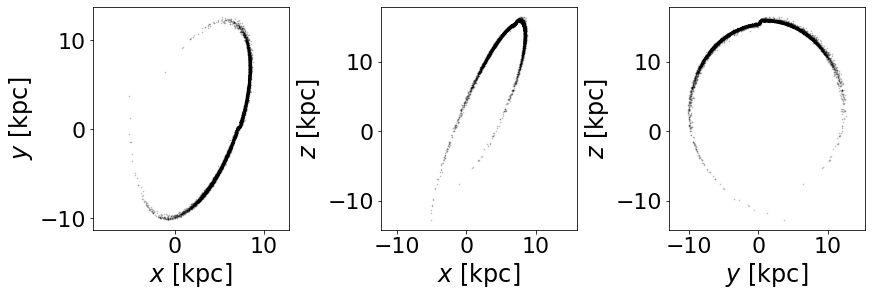

In [22]:
# Plot the stream
stream_style = dict(s=2, alpha=0.2, c='black')
_ = stream.plot(**stream_style)

Great this looks like Pal 5!